In [126]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pickle
import plotly.express as px
import pandas as pd

In [127]:
word_embeddings = np.load('word_embeddings.npy')

In [128]:
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

word2idx = tokenizer.word_index
idx2word = tokenizer.index_word

num_words = 100
words_to_visualize = [word for word in list(tokenizer.word_index.keys()) if len(word) > 3 and word.isalpha()][:num_words]
indices = [tokenizer.word_index[word] for word in words_to_visualize]

vectors = word_embeddings[indices]

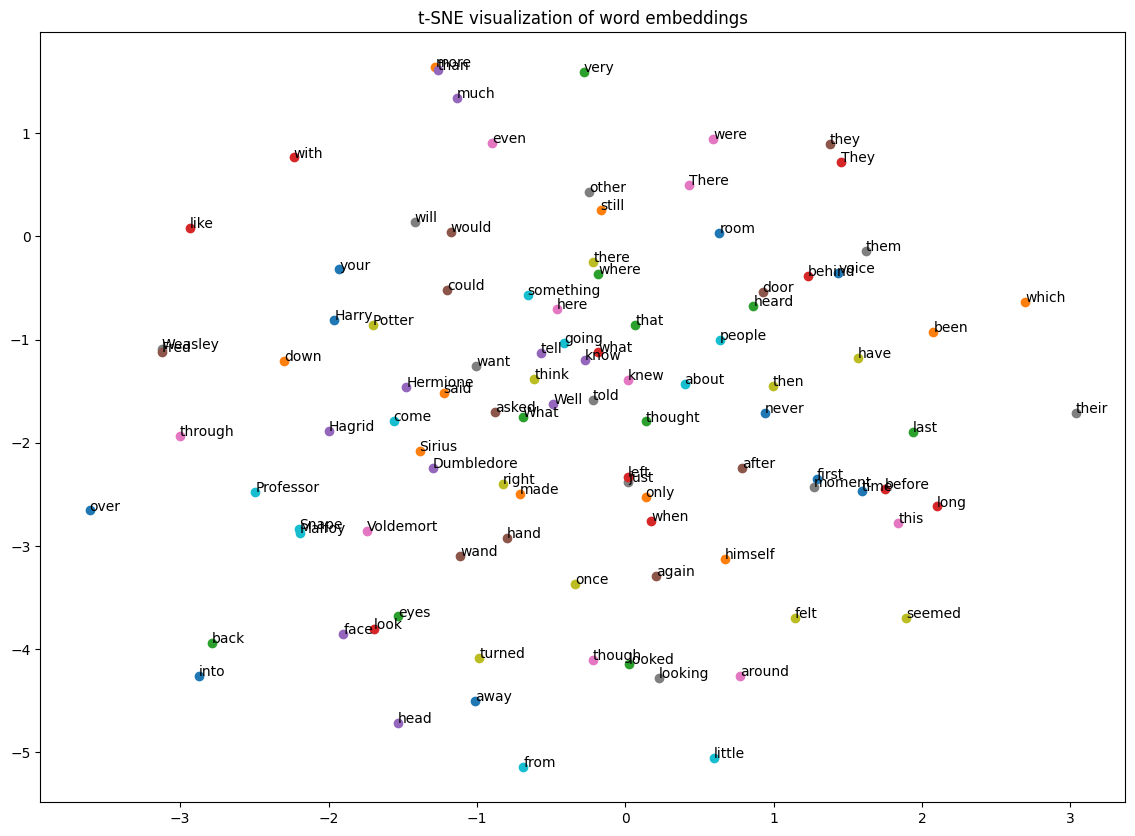

In [129]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
vectors_2d = tsne.fit_transform(vectors)

plt.figure(figsize=(14, 10))
for i, word in enumerate(words_to_visualize):
    x, y = vectors_2d[i]
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y))
plt.title('t-SNE visualization of word embeddings')
plt.show()

In [130]:
# Select themed words instead of just first 100
character_names = ["Harry", "Ron", "Hermione", "Dumbledore", "Voldemort", "Snape"]
houses = ["Gryffindor", "Hufflepuff", "Ravenclaw", "Slytherin"]
spells = ["Expelliarmus", "Accio", "Lumos", "Patronus", "Avada", "Kedavra"]

themed_words = character_names + houses + spells
# Filter for words in your vocabulary
themed_words = [w for w in themed_words if w in word2idx]
indices = [word2idx[word] for word in themed_words]

In [131]:
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
vectors_2d = tsne.fit_transform(word_embeddings[indices])
df = pd.DataFrame({
    'x': vectors_2d[:, 0],
    'y': vectors_2d[:, 1],
    'word': themed_words
})

fig = px.scatter(df, x='x', y='y', text='word', 
                 title='Word Embedding Visualization')
fig.update_traces(textposition='top center')
fig.show()

In [132]:
def find_similar_words(word, top_n=10):
    if word not in word2idx:
        return "Word not in vocabulary"
    
    word_vec = word_embeddings[word2idx[word]]
    similarities = []
    
    for w, idx in word2idx.items():
        if w == word:
            continue
        vec = word_embeddings[idx]
        # Compute cosine similarity
        similarity = np.dot(word_vec, vec) / (np.linalg.norm(word_vec) * np.linalg.norm(vec))
        similarities.append((w, similarity))
    
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:top_n]

print(find_similar_words("Harry"))
print(find_similar_words("magic"))

[('Potter', 0.48119104), ('’', 0.45423216), ('saw', 0.44326675), ('his', 0.4404838), ('”', 0.43158126), ('said', 0.423602), ('.', 0.41982654), ('watched', 0.41146016), (',', 0.41144812), ('missed', 0.40435776)]
[('spells', 0.5648972), ('without', 0.54340416), ('books', 0.50063676), ('or', 0.49783078), ('work', 0.46762118), ('chance', 0.460945), ('used', 0.4579078), ('our', 0.45688578), ('magical', 0.44003692), ('spell', 0.43917555)]


In [133]:
def word_analogy(word_a, word_b, word_c):
    """Find word_d such that word_a is to word_b as word_c is to word_d"""
    if not all(w in word2idx for w in [word_a, word_b, word_c]):
        return "One or more words not in vocabulary"
        
    # word_a - word_b + word_c ≈ word_d
    vector = (word_embeddings[word2idx[word_a]] - 
              word_embeddings[word2idx[word_b]] + 
              word_embeddings[word2idx[word_c]])
    
    similarities = []
    for word, idx in word2idx.items():
        if word in [word_a, word_b, word_c]:
            continue
        similarity = np.dot(vector, word_embeddings[idx]) / (
            np.linalg.norm(vector) * np.linalg.norm(word_embeddings[idx]))
        similarities.append((word, similarity))
        
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:5]

print(word_analogy("Harry", "Gryffindor", "Draco"))  # Should be Slytherin
print(word_analogy("Ron", "Weasley", "Harry"))
print(word_analogy("Hermione", "Granger", "Harry"))
print(word_analogy("Harry", "Potter", "Albus"))
print(word_analogy("Harry", "Potter", "Hermione"))
print(word_analogy("Harry", "Potter", "Ron"))

[('Malfoy', 0.4737602), ('stare', 0.40633094), ('spat', 0.39770174), ('saw', 0.39546412), ('Snape', 0.386407)]
[('wished', 0.41491026), ('missed', 0.38363796), ('book', 0.38009915), ('thought', 0.3772358), ('stared', 0.37512305)]
[('said', 0.4953426), ('Ron', 0.49351892), ('”', 0.4565314), ('shaking', 0.43381172), ('’', 0.42440033)]
[('turned', 0.44155207), ('Aberforth', 0.39300066), ('Dumbledore', 0.3889372), ('Hagrid', 0.37877104), ('suspected', 0.37813896)]
[('Ron', 0.50612664), ('Ginny', 0.47598165), ('climbed', 0.46126148), ('nervously', 0.43695325), ('”', 0.42681485)]
[('directions', 0.4388121), ('turned', 0.4363258), ('Ginny', 0.43277916), ('hastily', 0.42092368), ('climbed', 0.42038578)]


In [134]:
def word_addition(word_a, word_b):
    """Find word_c such that word_a + word_b ≈ word_c"""
    if not all(w in word2idx for w in [word_a, word_b]):
        return "One or more words not in vocabulary"
        
    vector = (word_embeddings[word2idx[word_a]] + 
              word_embeddings[word2idx[word_b]])
    
    similarities = []
    for word, idx in word2idx.items():
        if word in [word_a, word_b]:
            continue
        similarity = np.dot(vector, word_embeddings[idx]) / (
            np.linalg.norm(vector) * np.linalg.norm(word_embeddings[idx]))
        similarities.append((word, similarity))
        
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:5]

print(word_addition("Harry", "Gryffindor"))
print(word_addition("Ron", "Weasley"))
print(word_addition("Hermione", "Granger"))
print(word_addition("Harry", "Potter"))

print(word_addition("boy", "scar"))
print(word_addition("Harry", "animal"))
print(word_addition("Harry", "owl"))
print(word_addition("Harry", "sock"))

[('team', 0.5763183), ('match', 0.56488836), ('Hufflepuff', 0.5252228), ('Potter', 0.5204206), ('common', 0.5112834)]
[('Mrs', 0.705292), ('Mr', 0.67678267), ('Percy', 0.6387663), ('Fred', 0.56021655), ('Hermione', 0.5458442)]
[('Miss', 0.63114256), ('Ron', 0.5012056), ('whispered', 0.4985894), ('however', 0.49791902), ('laughed', 0.49782676)]
[('Dobby', 0.5334249), ('quietly', 0.46483988), ('said', 0.46458265), ('want', 0.45275238), ('hadn', 0.44689944)]
[('man', 0.6292805), ('happy', 0.56347024), ('father', 0.555354), ('mother', 0.5503166), ('Is', 0.5445359)]
[('saw', 0.5158557), ('closer', 0.4589649), ('’', 0.45723996), ('felt', 0.44626284), ('these', 0.44323516)]
[('letter', 0.5117197), ('Hedwig', 0.49894518), ('turned', 0.49477696), ('missed', 0.48096395), ('Dobby', 0.47674996)]
[('his', 0.48591965), ('Dobby', 0.4660026), ('threw', 0.45724228), ('”', 0.4426798), ('’', 0.4388127)]
